# init

In [ ]:
from imagenette_experiments.train_utils import *

In [ ]:
from kornia.contrib import MaxBlurPool2d

In [ ]:
from fastai.basic_train import *
from fastai.vision import *
from model_constructor.net import Net, act_fn, NewResBlock
from model_constructor.layers import SimpleSelfAttention, ConvLayer

# NewStem

In [ ]:
def _make_stem_new(self):
    '''4 layers, stem on conv1, groups'''
#         stride_on=1
#         stride_by_pool = False
    stem = []
    stem.append((f"conv_0", self.conv_layer(3,    32, stride=1, act_fn=self.act_fn, bn_1st=self.bn_1st)))
    stem.append((f"conv_1", self.conv_layer(32,   64, stride=2, act_fn=self.act_fn, bn_1st=self.bn_1st)))
    stem.append((f"conv_2", self.conv_layer(64,  128, stride=1, act_fn=self.act_fn, bn_1st=self.bn_1st,
                                          groups=16,)))
    stem.append((f"conv_3", self.conv_layer(128, 256, stride=1, act_fn=self.act_fn, bn_1st=self.bn_1st,
                                          groups=32,)))
#         if stride_by_pool:
#             stem.insert(stride_on, ('reduce_stem', self.stem_pool))
#             stem.insert(stride_on+1, ('reduce_bn', nn.BatchNorm2d(self.stem_sizes[stride_on])))
    stem.append(('stem_pool', self.stem_pool))
    if self.stem_bn_end: stem.append(('norm', self.norm(self.stem_sizes[-1])))
    return nn.Sequential(OrderedDict(stem))

In [ ]:
mixup = 0.1

In [ ]:
size = 192
bs = 32
epochs=20

# base model

In [ ]:
blurpool = MaxBlurPool2d(3, True)
maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

In [ ]:
model = Net(c_out=10, layers=[3,6,8,3], expansion=4)
model.act_fn = Mish()
model.stem_sizes = [3,32,64,64]

In [ ]:
model._make_stem = _make_stem_new

# MaxBlur on body 8812 0.0006 

In [ ]:
model.block = NewResBlock
model.groups = 4
model.stem_sizes = [3,32,64,128, 256]
model.pool = blurpool
model.sa = True

## model

In [ ]:
model.stem

Sequential(
  (conv_0): ConvLayer(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_fn): Mish()
  )
  (conv_1): ConvLayer(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_fn): Mish()
  )
  (conv_2): ConvLayer(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_fn): Mish()
  )
  (conv_3): ConvLayer(
    (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_fn): Mish()
  )
  (stem_pool): MaxPool2d(kernel_size=3, stride=2, 

In [ ]:
model.body

Sequential(
  (l_0): Sequential(
    (bl_0): NewResBlock(
      (convs): Sequential(
        (conv_0): ConvLayer(
          (conv): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act_fn): Mish()
        )
        (conv_1): ConvLayer(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act_fn): Mish()
        )
        (conv_2): ConvLayer(
          (conv): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (merge): Mish()
    )
    (bl_1): NewResBlock(
      (convs): Sequential(
        (conv_0): ConvLayer(
          (conv): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), 

In [ ]:
model.head

Sequential(
  (pool): AdaptiveAvgPool2d(output_size=1)
  (flat): Flatten()
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)

In [ ]:
learn = get_learn(model=model, size=size, bs=bs, mixup=mixup)

data path   /notebooks/data/imagewoof2


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

Learn path /notebooks/data/imagewoof2


In [ ]:
learn.summary()

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [32, 192, 192]       864        True      
______________________________________________________________________
BatchNorm2d          [32, 192, 192]       64         True      
______________________________________________________________________
Mish                 [2048, 6, 6]         0          False     
______________________________________________________________________
Conv2d               [64, 96, 96]         18,432     True      
______________________________________________________________________
BatchNorm2d          [64, 96, 96]         128        True      
______________________________________________________________________
Mish                 [2048, 6, 6]         0          False     
______________________________________________________________________
Conv2d               [128, 96, 96]        4,608      True      
___________________________________________________

#### lr find

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time


/opt/conda/conda-bld/pytorch_1591914855613/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value)


set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


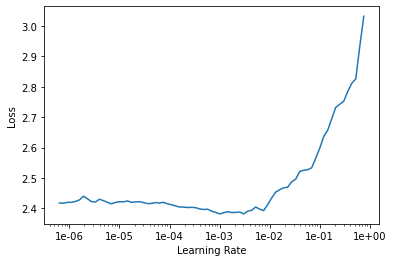

In [ ]:
learn.lr_find()
learn.recorder.plot()

## fit 8812 0.0006

In [ ]:
res = []

In [ ]:
learn = get_learn(model=model, size=size, bs=bs, mixup=mixup)
learn.fit_fc(epochs, lr=4e-3, moms=(0.95,0.95), start_pct=0.72)
res += [learn.recorder.metrics[-1][0].item()]

data path   /notebooks/data/imagewoof2


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

Learn path /notebooks/data/imagewoof2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.957657,1.849412,0.427590,0.863324,02:42
1,1.745054,1.522672,0.568338,0.928735,02:44
2,1.566940,1.314762,0.652838,0.951642,02:44
3,1.421221,1.220935,0.697887,0.958259,02:44
4,1.339397,1.167295,0.725630,0.967676,02:43
5,1.262633,1.081904,0.779588,0.977857,02:44
6,1.223907,1.072126,0.767371,0.974803,02:44
7,1.180104,1.004770,0.803767,0.975566,02:44
8,1.103243,1.005685,0.799949,0.978366,02:44
9,1.103966,0.955314,0.823110,0.981420,02:44


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


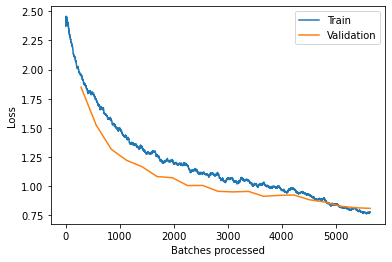

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn = get_learn(model=model, size=size, bs=bs, mixup=mixup)
learn.fit_fc(epochs, lr=4e-3, moms=(0.95,0.95), start_pct=0.72)
res += [learn.recorder.metrics[-1][0].item()]

data path   /notebooks/data/imagewoof2


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

Learn path /notebooks/data/imagewoof2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.921424,1.695242,0.477984,0.894121,02:46
1,1.702632,1.471469,0.575719,0.932807,02:46
2,1.528625,1.359813,0.636549,0.948333,02:45
3,1.398185,1.257338,0.687452,0.959532,02:45
4,1.345548,1.161090,0.727157,0.970985,02:45
5,1.286889,1.074414,0.778315,0.972258,02:45
6,1.201592,1.003061,0.804530,0.976584,02:46
7,1.146614,0.979969,0.809112,0.980148,02:45
8,1.140073,1.008370,0.796386,0.974548,02:45
9,1.079563,0.957529,0.818274,0.980657,02:45


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


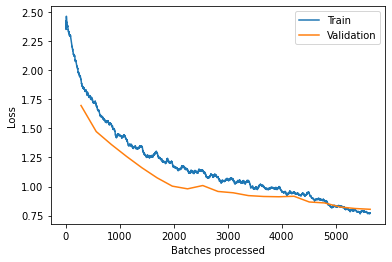

In [ ]:
learn.recorder.plot_losses()

### res 8812 0.0006 // 8000 0.0026 // 8083 0.0040 // 8058 0.0024 

In [ ]:
res

[0.8819037675857544, 0.8806312084197998]

In [ ]:
stat = np.array(res)

In [ ]:
stat.mean(), stat.std()

(0.8812674880027771, 0.0006362795829772949)

# Default Res block 8859 0.0017, 8834 0,0035

In [ ]:
model.block = NewResBlock
model.groups = 4
model.stem_sizes = [3,32,64,128, 256]
model.sa = True

## model

In [ ]:
model.stem

Sequential(
  (conv_0): ConvLayer(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_fn): Mish()
  )
  (conv_1): ConvLayer(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_fn): Mish()
  )
  (conv_2): ConvLayer(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_fn): Mish()
  )
  (conv_3): ConvLayer(
    (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_fn): Mish()
  )
  (stem_pool): MaxPool2d(kernel_size=3, stride=2, 

In [ ]:
model.body

Sequential(
  (l_0): Sequential(
    (bl_0): NewResBlock(
      (convs): Sequential(
        (conv_0): ConvLayer(
          (conv): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act_fn): Mish()
        )
        (conv_1): ConvLayer(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act_fn): Mish()
        )
        (conv_2): ConvLayer(
          (conv): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (merge): Mish()
    )
    (bl_1): NewResBlock(
      (convs): Sequential(
        (conv_0): ConvLayer(
          (conv): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), 

In [ ]:
model.head

Sequential(
  (pool): AdaptiveAvgPool2d(output_size=1)
  (flat): Flatten()
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)

In [ ]:
learn = get_learn(model=model, size=size, bs=bs, mixup=mixup)

data path   /notebooks/data/imagewoof2


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

Learn path /notebooks/data/imagewoof2


In [ ]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [32, 192, 192]       864        True      
______________________________________________________________________
BatchNorm2d          [32, 192, 192]       64         True      
______________________________________________________________________
Mish                 [2048, 6, 6]         0          False     
______________________________________________________________________
Conv2d               [64, 96, 96]         18,432     True      
______________________________________________________________________
BatchNorm2d          [64, 96, 96]         128        True      
______________________________________________________________________
Mish                 [2048, 6, 6]         0          False     
______________________________________________________________________
Conv2d               [128, 96, 96]        4,608      True      
___________________________________________________

### lr find

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time


/opt/conda/conda-bld/pytorch_1591914855613/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value)


set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


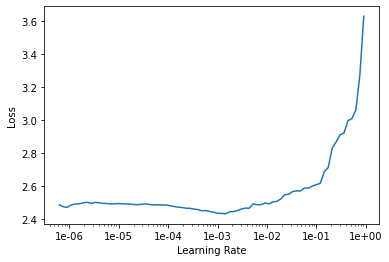

In [ ]:
learn.lr_find()
learn.recorder.plot()

## fit 8859 0.0017

In [ ]:
res = []

In [ ]:
learn = get_learn(model=model, size=size, bs=bs, mixup=mixup)
learn.fit_fc(epochs, lr=4e-3, moms=(0.95,0.95), start_pct=0.6)
res += [learn.recorder.metrics[-1][0].item()]

data path   /notebooks/data/imagewoof2


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

Learn path /notebooks/data/imagewoof2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.980591,1.784367,0.446933,0.892339,02:30
1,1.731073,1.558759,0.530669,0.936116,02:33
2,1.539286,1.365273,0.642403,0.950624,02:33
3,1.450897,1.208531,0.723848,0.963349,02:33
4,1.360962,1.142688,0.741410,0.970221,02:33
5,1.262348,1.110918,0.751591,0.972258,02:33
6,1.237260,1.037005,0.792823,0.978621,02:33
7,1.185407,1.054162,0.776533,0.979130,02:32
8,1.152277,0.981602,0.813184,0.978875,02:32
9,1.122571,0.993517,0.806312,0.977857,02:32


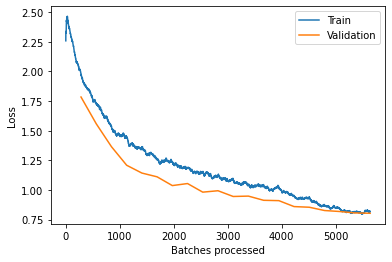

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn = get_learn(model=model, size=size, bs=bs, mixup=mixup)
learn.fit_fc(epochs, lr=4e-3, moms=(0.95,0.95), start_pct=0.6)
res += [learn.recorder.metrics[-1][0].item()]

data path   /notebooks/data/imagewoof2


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

Learn path /notebooks/data/imagewoof2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.016916,1.812376,0.424790,0.878341,02:32
1,1.753871,1.593058,0.530669,0.921354,02:32
2,1.576044,1.341733,0.644948,0.948842,02:31
3,1.436261,1.187538,0.723339,0.963858,02:33
4,1.344829,1.156709,0.740646,0.971749,02:32
5,1.283816,1.119618,0.763553,0.967931,02:33
6,1.228706,1.052561,0.789005,0.972767,02:33
7,1.158662,0.994912,0.809366,0.978366,02:33
8,1.133961,1.044197,0.788750,0.975312,02:33
9,1.113418,0.959920,0.822601,0.982693,02:33


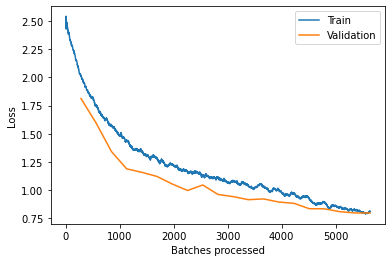

In [ ]:
learn.recorder.plot_losses()

### res 8859 0.0017

In [ ]:
res

[0.8841944336891174, 0.8877577185630798]

In [ ]:
stat = np.array(res)

In [ ]:
stat.mean(), stat.std()

(0.8859760761260986, 0.0017816424369812012)

## fit 8834 0,0035 

In [ ]:
res = []

In [ ]:
learn = get_learn(model=model, size=size, bs=bs, mixup=mixup)
learn.fit_fc(epochs, lr=4e-3, moms=(0.95,0.95), start_pct=0.4)
res += [learn.recorder.metrics[-1][0].item()]

data path   /notebooks/data/imagewoof2


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

Learn path /notebooks/data/imagewoof2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.972140,1.754419,0.457368,0.890812,02:24
1,1.716003,1.478285,0.584627,0.944770,02:29
2,1.559357,1.332183,0.641639,0.960041,02:28
3,1.429681,1.215868,0.702723,0.966658,02:29
4,1.324682,1.132926,0.747009,0.974548,02:28
5,1.305773,1.131134,0.746500,0.970221,02:28
6,1.241634,1.031520,0.791805,0.976075,02:28
7,1.149412,0.990187,0.813948,0.980657,02:28
8,1.145859,0.968828,0.822601,0.982184,02:28
9,1.105210,0.960134,0.818020,0.982693,02:29


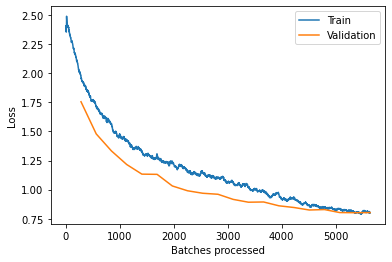

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn = get_learn(model=model, size=size, bs=bs, mixup=mixup)
learn.fit_fc(epochs, lr=4e-3, moms=(0.95,0.95), start_pct=0.4)
res += [learn.recorder.metrics[-1][0].item()]

data path   /notebooks/data/imagewoof2


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

Learn path /notebooks/data/imagewoof2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.998647,1.814388,0.426317,0.871723,02:28
1,1.737557,1.579074,0.546195,0.918300,02:27
2,1.573092,1.347756,0.641894,0.953678,02:28
3,1.452082,1.253905,0.687961,0.961822,02:29
4,1.351027,1.154942,0.737083,0.969712,02:29
5,1.287272,1.098311,0.762280,0.972512,02:29
6,1.224073,1.042693,0.784169,0.976584,02:28
7,1.195007,1.026473,0.790532,0.975566,02:28
8,1.174225,0.977411,0.815729,0.978112,02:29
9,1.137885,0.970794,0.810130,0.978875,02:29


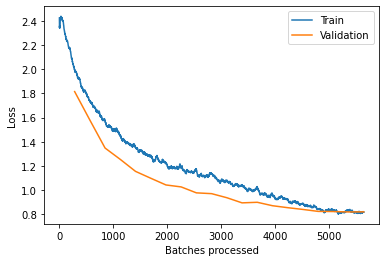

In [ ]:
learn.recorder.plot_losses()

### res 8834 0,0035

In [ ]:
res

[0.8869941234588623, 0.879867672920227]

In [ ]:
stat = np.array(res)

In [ ]:
stat.mean(), stat.std()

(0.8834308981895447, 0.003563225269317627)

# pip freeze

In [ ]:
!pip freeze

apex @ git+https://github.com/NVIDIA/apex@459de22d59c64e30fd4b368c368c5b74e269f3dd
attrs==19.3.0
backcall==0.2.0
beautifulsoup4==4.9.1
bleach==3.1.5
blis==0.4.0
Bottleneck==1.3.2
brotlipy==0.7.0
catalogue==1.0.0
certifi==2020.6.20
cffi==1.14.0
chardet==3.0.4
conda==4.8.3
conda-build==3.18.11
conda-package-handling==1.7.0
cryptography==2.9.2
cycler==0.10.0
cymem==2.0.2
dataclasses==0.6
decorator==4.4.2
defusedxml==0.6.0
entrypoints==0.3
fastai==1.0.61
fastcore==0.1.18
fastprogress==0.2.2
fastscript==0.1.4
filelock==3.0.12
future==0.18.2
glob2==0.7
idna @ file:///tmp/build/80754af9/idna_1593446292537/work
-e git+https://github.com/ayasyrev/imagenette_experiments@10a30e5ab5b4acdacf01c377829ff8846287420c#egg=imagenette_experiments
importlib-metadata @ file:///tmp/build/80754af9/importlib-metadata_1593446408836/work
ipykernel @ file:///tmp/build/80754af9/ipykernel_1595347145358/work/dist/ipykernel-5.3.3-py3-none-any.whl
ipython @ file:///tmp/build/80754af9/ipython_1593447368578/work
ipython